# Dataset analysis
There are two samples of social networks to analyse in this study : Epinions and Delicious.
We'll be using two files for the two of them, hence 4 files.
For each dataset there are a file for a user-user graph, and a file for a user-item graph.
+ Epinions : trust relashionships are unidirectional, an item is about an online buyable item on which a user lend a rewiew with a rating.
+ Delicious : contact relashonships are reciprocal, an item is a tag associated with a bookmark made by a user.

Overall, we want to make statistics over 2 kinds connexions in each social networks : we'll first check about relationship between users, then between users and items.

In [1]:
!pip3 install networkx

    100% |████████████████████████████████| 1.6MB 144kB/s ta 0:00:01


In [81]:
import networkx as nx
import pandas as pd
import numpy as np

## Epinions - user-user dataset

We must first clean the mess within Epinions trust dataset in order to import it in a NetworkX graph.

In [82]:
path_trust_epi = './trust_data.txt'
path_trust_epi_clean = './trust_data_clean.txt'

In [83]:
import os
def remove_space(path,path_clean):
    if os.path.exists(path_clean):
        os.remove(path_clean)
    with open(path_clean, 'w') as file_clean:
        with open(path, 'r') as file:
            for line in file:
                file_clean.write(line[1:-1]+'\n')

In [84]:
remove_space(path_trust_epi,path_trust_epi_clean)

In [85]:
G = nx.read_edgelist(path_trust_epi_clean, create_using=nx.DiGraph, nodetype=int, data=(("weight", int),))

### Size

In [86]:
trust_size = len(G.nodes)
trust_nb_edges = len(G.edges)

print("nodes (users):", trust_size, "|", "edges (trust relations):", trust_nb_edges)
print("mean number of trust relation per user:", trust_nb_edges/trust_size)

nodes (users): 49288 | edges (trust relations): 487183
mean number of trust relation per user: 9.884414056159715


### Distribution

In [87]:
import matplotlib.pyplot as plt

def plot_degree_dist(nodes,degree_func,bin_size):
    degrees = [degree_func(n) for n in nodes]
    plt.yscale('log')
    #plt.xscale('log')
    density = plt.hist(degrees, bins=[i for i in range(0,max(degrees)+bin_size,bin_size)])
    plt.show()
    return density

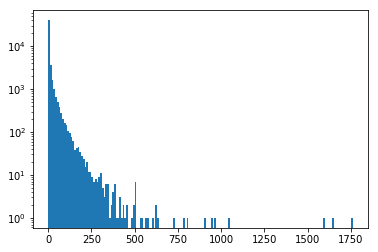

In [90]:
density = plot_degree_dist(G.nodes(),G.out_degree,10)

In [91]:
print(max(density[0])/trust_size,np.argmax(density[0]))

0.8129970783963643 0


The size of the bins are currently 10 (mostly 10 in the following histograms) and the Y-scale is logarithmic in every histogram we'll show. Indeed the datasets we are looking into have the same distribution laws in terms of connexion between users, but also between users and items.


The most populated interval for out degree distribution is [0, 9] (second is [10, 19], then [20, 29], etc).
Here we have 81\% of the users who trust less than 9 other users. This first bin already contains most of the users.

In [92]:
print("number of isolated nodes : ",len(list(nx.isolates(G))))

number of isolated nodes :  0


There is no isolated node in this dataset, so it means 70% users trust between 1 and 4 other users.

### Distribution law
We can see that our Epinions trust dataset follows a Pareto distribution. This is the 80-20 repartition type of the exponential distribution law, which means the first class is 80% of the total population, the second most is way less represented than the first, etc. Here our classes are filled with the number of users that have their number of trusted users within a particular interval of constant size (= 10).

### Graph Density

In [52]:
nx.density(G)

0.00020054809698621774

Our social media has a very low density, which means that the user-user matrix will be very sparse.

### Matrix sparcity in a user-user graph representation

The matrix sparcity degree is given by the total size of the matrix `(n*m)` less twice the number of edges `e` for a symetrical matrix (representing an undirected graph) divided by the size of the matrix : `((n*m)-2*e)/(m*n)`

In the case of a directed graph, the matrix is not symetrical, so the formula is `((n*m)-e)/(m*n)`. User-items matrix are always considered directed in this calculation.

This sparcity degree is between 0 and 1. 0 for a fully connected graph (hence matrix full of 0) or 1 if the graph is fully disconnected.

In [93]:
def matrix_sparcity(n,m,e,directed=False):
    a = 2
    if directed :
        a = 1
    return ((n*m)-a*2)/(n*m)

In [110]:
matrix_sparcity(trust_size,trust_size,trust_nb_edges,True)

0.9999999991767199

With a matrix this sparse, it is necessary to go through methods such as singular value decomposition (SVD) to reduce the effect of sparcity before doing machine learning with the matrix representation of the graph.

## Delicious - user-user dataset

In [99]:
path_contact_del = './user_contacts-timestamps.dat'

In [100]:
data = np.genfromtxt(path_contact_del,
                     skip_header=1,
                     dtype=int,
                     names=True,
                     usecols=(0,1),
                     delimiter='\t')

In [101]:
G_del = nx.from_edgelist(data)

Note that this time, the graph is undirected.

### Size

In [102]:
contact_size = len(list(G_del.edges))
user_size = len(list(G_del.nodes))
print("edges:",contact_size,"| nodes:", user_size)
print("mean number of contact relation per user:", contact_size/user_size)

edges: 7664 | nodes: 1861
mean number of contact relation per user: 4.118216012896292


In [103]:
print("number of isolated nodes : ",len(list(nx.isolates(G_del))))

number of isolated nodes :  0


### Distribution

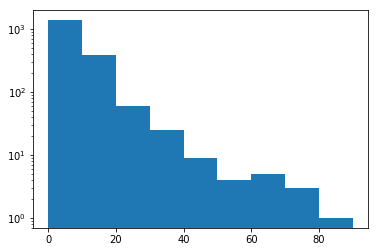

In [104]:
density_del = plot_degree_dist(G_del.nodes(),G_del.degree,10)

In [105]:
print(max(density_del[0])/user_size,np.argmax(density_del[0]))

0.7345513164965073 0


This time we take a bin size of 10 since we can see more clarly in the histogram.

We observe the same phenomenom : 73\% of users have between 1 and 9 contacts, even with an undirected graph.

### Distribution law
Same as the previous dataset for the relationships between users : Pareto distribution

### Density

In [107]:
nx.density(G_del)

0.0044281892611788085

This dataset is a lot less sparce than Epinions, which means that the Delicious user-user matrix will be sparse
but a lot less that what we estimated in Epinions. It is a bit obvious since this graph is undirected and the Epinions' relationship between users are non-reciprocal, hence the edges are directed.

### Matrix sparcity

In [109]:
matrix_sparcity(user_size,user_size,contact_size)

0.9999988450391979

## Epinions - User-items dataset

In [34]:
rating_path = "./ratings_data.txt"

In [35]:
#G_epi_ui = nx.bipartite.read_edgelist(rating_path,
#                                      create_using=nx.DiGraph,
#                                      nodetype=int,
#                                      data=(("rating", int),))

In [36]:
df = pd.read_csv(rating_path, sep=' ', header=None, names=["Users", "Items","Ratings"], 
                 dtype={"Users":'int',"Items":'str',"Ratings":'int'}
                )

In [38]:
G_ui_epi = nx.Graph()

users_set_epi = df['Users'].drop_duplicates()
items_set_epi = df['Items'].drop_duplicates()

G_ui_epi.add_nodes_from(users_set_epi,bipartite=0)
G_ui_epi.add_nodes_from(items_set_epi,bipartite=1)


In [39]:
#G_ui_epi.add_weighted_edges_from(
#    [(row['Users'], row['Items'], row['Ratings']) for idx, row in df.iterrows()], 
#    weight='rating')
G_ui_epi.add_weighted_edges_from(df.values,weight='rating')

In [40]:
print("Is graph bipartite ? :",nx.is_bipartite(G_ui_epi))

Is graph bipartite ? : True


### Size

In [41]:
users_size_epi = len(users_set_epi)
items_size_epi = len(items_set_epi)
rating_nb_edges = len(G_ui_epi.edges)

print("users nodes:", users_size_epi, "| items nodes:", items_size_epi, "| edges (rating):", rating_nb_edges)
print("mean number of ratings per user:", rating_nb_edges/users_size_epi)

users nodes: 40163 | items nodes: 139738 | edges (rating): 664824
mean number of ratings per user: 16.55314593033389


In [42]:
print("number of isolated nodes : ",len(list(nx.isolates(G_ui_epi))))

number of isolated nodes :  0


### Distribution
Let's start with the user nodes of this user-item dataset

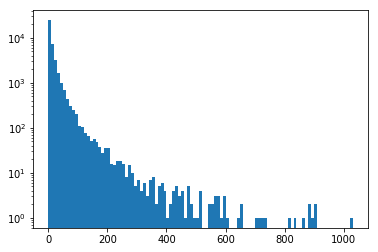

In [43]:
density_epi_ui_u = plot_degree_dist(users_set_epi,G_ui_epi.degree,10)

In [44]:
print(max(density_epi_ui_u[0])/users_size_epi,np.argmax(density_epi_ui_u[0]))

0.6069516719368573 0


We can see that 61\% of users rated less than 10 items.

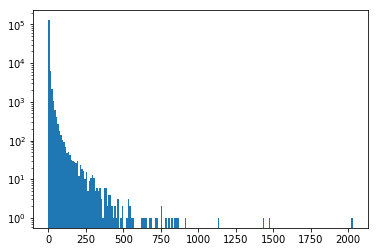

In [45]:
density_epi_ui_i = plot_degree_dist(items_set_epi,G_ui_epi.degree,10)

In [46]:
print(max(density_epi_ui_i[0])/items_size_epi,np.argmax(density_epi_ui_i[0]))

0.916579598963775 0


92\% of items are only being reviewed between 1 and 9 times by the users from this dataset.

### Distribution law
Same as the previous dataset for the relationships between users. It's a Pareto distribution for both user degrees and items degrees, but the gradient is less steep from the inactive users to the more active ones.

### Stars repartition

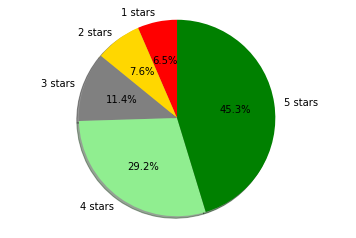

In [115]:
import matplotlib.pyplot as plt

n_bins = 5
df_stars = df.groupby("Ratings").size()

labels = [ str(i) + " stars" for i in range(1,6)]
sizes = list(df_stars.values)
colors = ['red', 'gold', 'gray', 'lightgreen','green']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.savefig('PieChartEpinions.png')
plt.show()


We can see that most reviews on Epinions site are 4 and 5 stars reviews, if this dataset is actually representative of the website.

### Density

In [21]:
print(nx.algorithms.bipartite.density(G_ui_epi, items_set))
print(nx.algorithms.bipartite.density(G_ui_epi, users_set))
print(nx.density(G_ui_epi))

0.0001184584431602992
0.0001184584431602992
4.108392652831394e-05


Here we can see that the graph density does not really match what we can read in the study

### Matrix sparcity

In [111]:
matrix_sparcity(users_size_epi,items_size_epi,rating_nb_edges,True)

0.9999999996436397

## Delicious - User-items dataset

In [5]:
tags_path = "user_taggedbookmarks-timestamps.dat"

In [6]:
data_tags = np.genfromtxt(tags_path,
                     skip_header=1,
                     dtype=int,
                     names=True,
                     usecols=(0,2),
                     delimiter='\t')

In [7]:
df_del = pd.read_csv(tags_path, sep='\t', usecols=["userID","tagID"],
                     dtype={"userID":'int',"tagID":'str'}
                    )

#G_del = nx.from_edgelist(data)

In [8]:
tag_weights = df_del.groupby(["userID","tagID"]).size().reset_index()

In [9]:
tag_weights.columns = ["userID","itemID","weight"]

In [10]:
G_ui_del = nx.Graph()

users_set_del = tag_weights['userID'].drop_duplicates()
items_set_del = tag_weights['itemID'].drop_duplicates()

G_ui_del.add_nodes_from(users_set_del,bipartite=0)
G_ui_del.add_nodes_from(items_set_del,bipartite=1)

In [11]:
G_ui_del.add_weighted_edges_from(tag_weights.values,weight='weight')

### Size

In [20]:
users_size_del = len(users_set_del)
items_size_del = len(items_set_del)
tags_nb_edges = len(G_ui_del.edges)

print("nodes user:",users_size_del,"| nodes item:",items_size_del,"| edges (tags):",tags_nb_edges)
print("average number of tags per user:", tags_nb_edges/users_size_del)

nodes user: 1867 | nodes item: 40897 | edges (tags): 230942
average number of tags per user: 123.69683985002678


### Distribution

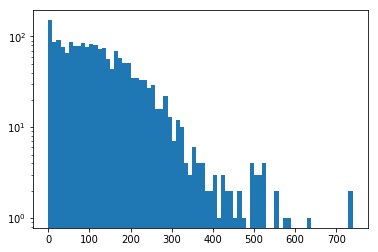

In [21]:
density_del_ui_u = plot_degree_dist(users_set_del,G_ui_del.degree,10)

In [30]:
def median_class(density_bins, size, bin_size):
    i = 0
    sum_prob = 0.0
    while sum_prob < 0.5 :
        sum_prob += density_bins[i]/size
        i += 1
    return sum_prob, (i*bin_size), (i+1)*bin_size-1

In [31]:
median_class(density_del_ui_u[0],users_size_del,10)

(0.5141938939475094, 110, 119)

The median class here is [110, 119], which means than the median number of unique tags per user is between 110 and 119 tags.

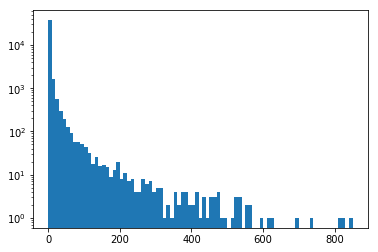

In [114]:
density_del_ui_i = plot_degree_dist(items_set_del,G_ui_del.degree,10)

In [129]:
print(max(density_del_ui_i[0])/items_size_del,np.argmax(density_del_ui_i[0]))

0.9171332860601022 0


92% of the tags are being used only a few times, between 1 and 9 times.

In [63]:
df_total_user = tag_weights.groupby("userID").sum().reset_index()

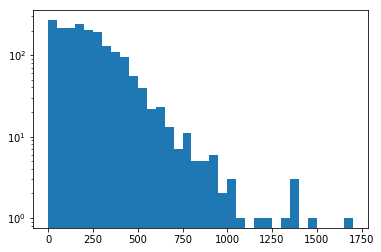

In [78]:
bin_size = 50
totals = df_total_user['weight'].values
plt.yscale('log')
#plt.xscale('log')
density_total = plt.hist(totals, bins=[i for i in range(0,max(totals)+bin_size,bin_size)])
plt.show()

In [79]:
median_class(density_total[0],users_size_del,50)

(0.5018746652383503, 200, 249)

The median user have put between 200 and 209 tags in their bookmarks.

### Distribution laws

+ user degrees : follows an exponential law but not very steep
+ item degrees : very steep exponential law (Pareto)
+ total number of tags per user: follows an exponential law but not very steep

### Matrix sparcity

In [114]:
matrix_sparcity(users_size_del,items_size_del,tags_nb_edges,True)

0.9999999738064582

Very empty as usual